## Day 28 Lecture 1 Assignment

In this assignment, we will learn about making predictions with linear models. We will use the king county housing dataset loaded below and analyze the regression from this dataset.

In [1]:
%matplotlib inline

import math
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pylab

from sklearn.model_selection import train_test_split
from sklearn import linear_model
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import acf
from sklearn_pandas import DataFrameMapper

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
king_county = pd.read_csv('https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/kc_house_data.csv')

In [3]:
king_county.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


We'll start by filtering out columns and keeping only: price, bedrooms, bathrooms, sqft_living, floors, and waterfront.

In [4]:
# answer below:
features = ['price', 'bedrooms', 'bathrooms', 'sqft_living', 'floors', 'waterfront']
kc_df = king_county.copy()
kc_df = kc_df[features]
kc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   price        21613 non-null  float64
 1   bedrooms     21613 non-null  int64  
 2   bathrooms    21613 non-null  float64
 3   sqft_living  21613 non-null  int64  
 4   floors       21613 non-null  float64
 5   waterfront   21613 non-null  int64  
dtypes: float64(3), int64(3)
memory usage: 1013.2 KB


Next create a pair plot in Seaborn to see the relationships between your features.

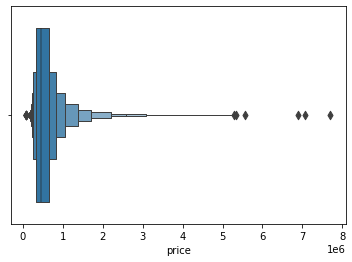

In [5]:
sns.boxenplot(x=kc_df['price'])
plt.show()

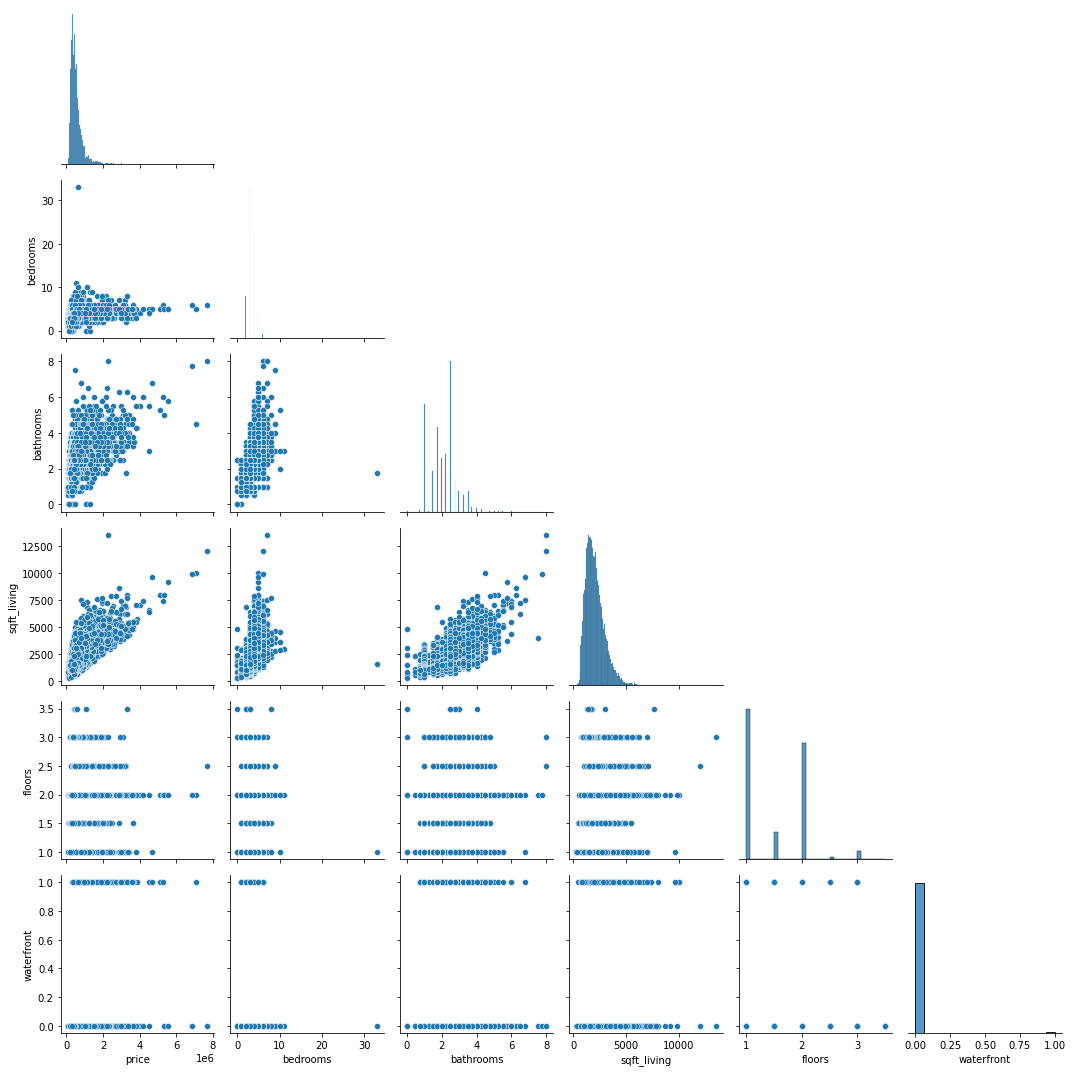

In [6]:
# answer below:
sns.pairplot(kc_df, corner=True)

plt.tight_layout()
plt.show()

There are two noticeable outliers here that will cause problems. Remove them.

In [7]:
# answer below:
kc_df.loc[kc_df['bedrooms'] > 20]

,price,bedrooms,bathrooms,sqft_living,floors,waterfront
15870,640000.0,33,1.75,1620,1.0,0


In [8]:
kc_df.loc[kc_df['price'] > 4000000]

,price,bedrooms,bathrooms,sqft_living,floors,waterfront
1164,5110800.0,5,5.25,8010,2.0,1
1315,5300000.0,6,6.00,7390,2.0,1
1448,5350000.0,5,5.00,8000,2.0,0
2626,4500000.0,5,5.50,6640,2.0,1
3914,7062500.0,5,4.50,10040,2.0,1
4411,5570000.0,5,5.75,9200,2.0,0
7252,7700000.0,6,8.00,12050,2.5,0
8092,4668000.0,5,6.75,9640,1.0,1
8638,4489000.0,4,3.00,6430,2.0,0
9254,6885000.0,6,7.75,9890,2.0,0


In [9]:
kc_df.loc[kc_df['sqft_living'] > 10000]

,price,bedrooms,bathrooms,sqft_living,floors,waterfront
3914,7062500.0,5,4.5,10040,2.0,1
7252,7700000.0,6,8.0,12050,2.5,0
12777,2280000.0,7,8.0,13540,3.0,0


In [10]:
kc_df.drop(kc_df[kc_df['bedrooms'] > 30].index, inplace=True)
kc_df.drop(kc_df[kc_df['price'] > 4000000].index, inplace=True)
kc_df.drop(kc_df[kc_df['sqft_living'] > 10000].index, inplace=True)

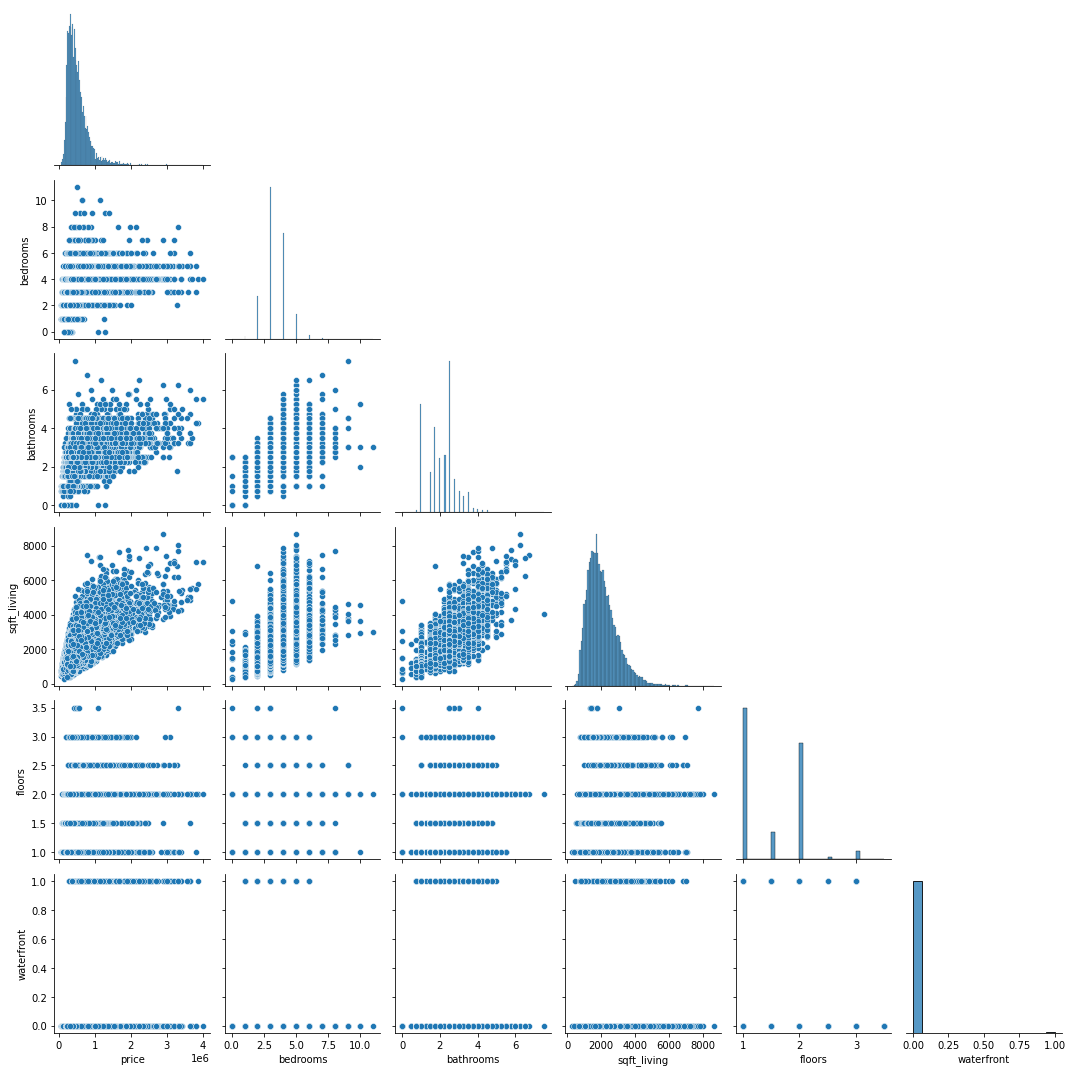

In [11]:
sns.pairplot(kc_df, corner=True)

plt.tight_layout()
plt.show()

Next, we'll check for missing values and remove rows containing missing values. We will also make sure that all our data is numeric and convert the columns that are of object type to numeric. Make sure to remove any rows with missing data resulting from the conversion to numeric.

In [12]:
# answer below:
missing_values = kc_df.isnull().sum()/kc_df.isnull().count()

missing_values

price          0.0
bedrooms       0.0
bathrooms      0.0
sqft_living    0.0
floors         0.0
waterfront     0.0
dtype: float64

In [13]:
kc_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21600 entries, 0 to 21612
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   price        21600 non-null  float64
 1   bedrooms     21600 non-null  int64  
 2   bathrooms    21600 non-null  float64
 3   sqft_living  21600 non-null  int64  
 4   floors       21600 non-null  float64
 5   waterfront   21600 non-null  int64  
dtypes: float64(3), int64(3)
memory usage: 1.2 MB


In [14]:
kc_df.describe()

,price,bedrooms,bathrooms,sqft_living,floors,waterfront
count,2.160000e+04,21600.000000,21600.000000,21600.000000,21600.000000,21600.000000
mean,5.374612e+05,3.368380,2.112639,2076.064028,1.494028,0.007315
std,3.484115e+05,0.906883,0.764294,902.694718,0.539891,0.085215
min,7.500000e+04,0.000000,0.000000,290.000000,1.000000,0.000000
25%,3.213818e+05,3.000000,1.750000,1420.000000,1.000000,0.000000
50%,4.500000e+05,3.000000,2.250000,1910.000000,1.500000,0.000000
75%,6.450000e+05,4.000000,2.500000,2550.000000,2.000000,0.000000
max,4.000000e+06,11.000000,7.500000,8670.000000,3.500000,1.000000


In [15]:
kc_df.corr()

,price,bedrooms,bathrooms,sqft_living,floors,waterfront
price,1.000000,0.316835,0.519847,0.694847,0.263465,0.248452
bedrooms,0.316835,1.000000,0.527392,0.592815,0.179998,-0.012104
bathrooms,0.519847,0.527392,1.000000,0.750918,0.501784,0.053104
sqft_living,0.694847,0.592815,0.750918,1.000000,0.355535,0.088821
floors,0.263465,0.179998,0.501784,0.355535,1.000000,0.022586
waterfront,0.248452,-0.012104,0.053104,0.088821,0.022586,1.000000


Split the data into test and train subsets. Use 20% of the data for the test subset. Use price as the dependent variable.

In [16]:
# mapper = DataFrameMapper([(kc_df.columns, MinMaxScaler())])
# scaled_features = mapper.fit_transform(kc_df.copy())
# scaled_kc_df = pd.DataFrame(scaled_features, index=kc_df.index, columns=kc_df.columns)

# scaled_kc_df

In [17]:
# answer below:
# y_log = pd.Series(np.log(kc_df['price']), index=kc_df.index)
y = kc_df['price']
X = kc_df.drop(['price'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Check the model assumptions: homoscedacity, normal errors, and multicollinearity

Mean of Errors: 2006.218


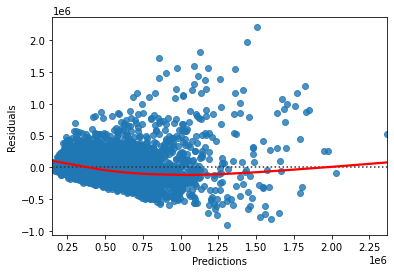

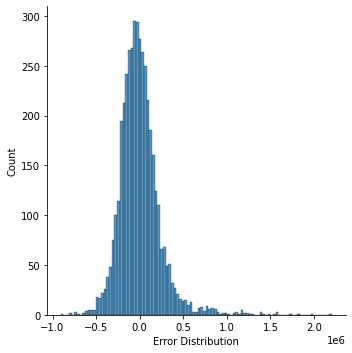

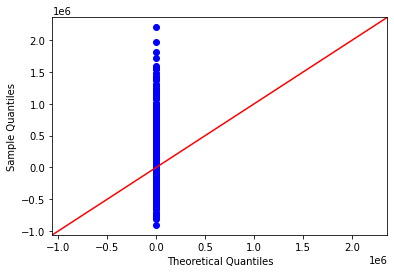

const          19.796755
bedrooms        1.622128
bathrooms       2.770736
sqft_living     2.643609
floors          1.355750
waterfront      1.017309
dtype: float64


In [18]:
# answer below
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

lrm = linear_model.LinearRegression()

lrm.fit(X_train, y_train)

y_preds = pd.Series(lrm.predict(X_test), index=X_test.index)

errors = y_test - y_preds

print(f'Mean of Errors: {np.mean(errors):.3f}')

sns.residplot(x=y_preds, y=errors, lowess=True, line_kws={'color':'red'})
plt.xlabel('Predictions')
plt.ylabel('Residuals')
plt.show()

sns.displot(errors)
plt.xlabel('Error Distribution')
plt.show()

sm.qqplot(errors, line='45')
plt.show()

vif = pd.Series([variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])],
          index=X_train.columns)
print(vif)

Mean of Errors: 0.003


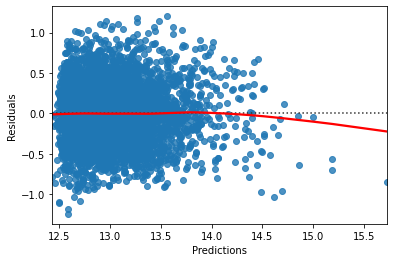

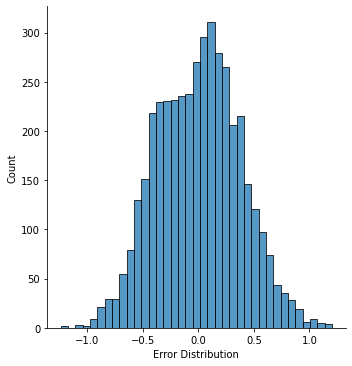

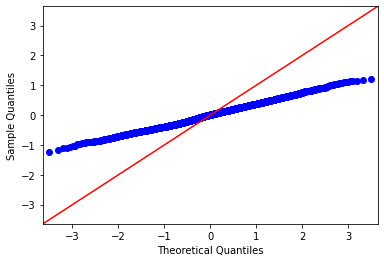

const          19.796755
bedrooms        1.622128
bathrooms       2.770736
sqft_living     2.643609
floors          1.355750
waterfront      1.017309
dtype: float64


In [19]:
lrm_log = linear_model.LinearRegression()

lrm_log.fit(X_train, np.log(y_train))

y_log_preds = pd.Series(lrm_log.predict(X_test), index=X_test.index)

errors = np.log(y_test) - y_log_preds

print(f'Mean of Errors: {np.mean(errors):.3f}')

sns.residplot(x=y_log_preds, y=errors, lowess=True, line_kws={'color':'red'})
plt.xlabel('Predictions')
plt.ylabel('Residuals')
plt.show()

sns.displot(errors)
plt.xlabel('Error Distribution')
plt.show()

sm.qqplot(errors, line='45')
plt.show()

vif = pd.Series([variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])],
          index=X_train.columns)
print(vif)

Create your final linear model and produce a model summary. Look at the coefficients and interpret their meaning. How do each of them influence the final prediction?

In [20]:
#answer below:
results = sm.OLS(y_train, X_train).fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.532
Model:                            OLS   Adj. R-squared:                  0.532
Method:                 Least Squares   F-statistic:                     3933.
Date:                Wed, 21 Oct 2020   Prob (F-statistic):               0.00
Time:                        19:57:21   Log-Likelihood:            -2.3845e+05
No. Observations:               17280   AIC:                         4.769e+05
Df Residuals:                   17274   BIC:                         4.770e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        8.247e+04   8059.911     10.232      

In [21]:
log_results = sm.OLS(np.log(y_train), X_train).fit()

print(log_results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.503
Model:                            OLS   Adj. R-squared:                  0.503
Method:                 Least Squares   F-statistic:                     3496.
Date:                Wed, 21 Oct 2020   Prob (F-statistic):               0.00
Time:                        19:57:21   Log-Likelihood:                -7301.0
No. Observations:               17280   AIC:                         1.461e+04
Df Residuals:                   17274   BIC:                         1.466e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          12.2422      0.012    979.487      

Predict the y values for the test sample using our model above.

Plot the true vs. predicted values and compute the MAE, MSE, RMSE and MAPE. How accurate is our model?

In [22]:
def mean_absolute_percentage_error(y_test, y_preds):
  return np.mean(np.abs((y_test - y_preds) / y_test)) * 100

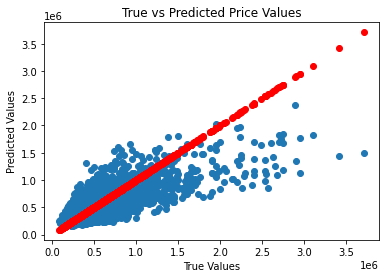

In [23]:
# answer below:
plt.scatter(y_test, y_preds)
plt.scatter(y_test, y_test, color='red')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Price Values')
plt.show()

In [24]:
print(f'MAE: {mean_absolute_error(y_test, y_preds)}')
print(f'MSE: {mean_squared_error(y_test, y_preds)}')
print(f'RMSE: {mean_squared_error(y_test, y_preds, squared=False)}')
print(f'MAPE: {mean_absolute_percentage_error(y_test, y_preds)}')
print(f'R2: {r2_score(y_test, y_preds)}')

MAE: 168248.57076385952
MSE: 59137735053.312126
RMSE: 243182.5138724249
MAPE: 34.964074744306785
R2: 0.5154809066844087


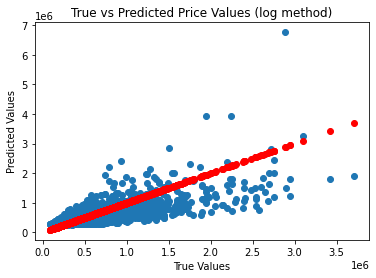

In [25]:
plt.scatter(y_test, np.exp(y_log_preds))
plt.scatter(y_test, y_test, color='red')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Price Values (log method)')
plt.show()

In [26]:
print(f'Log MAE: {mean_absolute_error(y_test, np.exp(y_log_preds))}')
print(f'Log MSE: {mean_squared_error(y_test, np.exp(y_log_preds))}')
print(f'Log RMSE: {mean_squared_error(y_test, np.exp(y_log_preds), squared=False)}')
print(f'Log MAPE: {mean_absolute_percentage_error(y_test, np.exp(y_log_preds))}')
print(f'Log R2: {r2_score(np.log(y_test), y_log_preds)}')

Log MAE: 162282.64409288278
Log MSE: 63053301075.08931
Log RMSE: 251104.1637948071
Log MAPE: 31.625108229243796
Log R2: 0.49075017792564135


In [27]:
print(f'Log R2: {r2_score(y_test, np.exp(y_log_preds))}')

Log R2: 0.4834004339206388
